In [1]:
# import all the required libraries in this place


import json
import csv
import threading
import math
import pandas as pd
import numpy as np
import multiprocessing
import random as rn

import seaborn as sns
import matplotlib.pyplot as plt



# from data import data_visualization, data_loading, data_preprocessing
# from models import annModels

# from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report 
from sklearn.model_selection import  learning_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.decomposition import PCA
from scikeras.wrappers import KerasClassifier

# import xgboost as xgb

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.models import Model

import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Activation, Dropout, Activation
from keras.optimizers import SGD
from keras.models import load_model
from keras import regularizers
from keras import backend as K
from keras.layers import BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Conv2D, MaxPooling2D
from keras.regularizers import l2
from keras.layers import concatenate
from sklearn.model_selection import StratifiedKFold

import joblib

2024-08-19 17:24:26.782853: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-19 17:24:26.796586: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-19 17:24:26.812960: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-19 17:24:26.817452: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-19 17:24:26.829282: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# Function to load dataset from JSONL files with error handling
def load_dataset_from_jsonl(file_path, file_idx_start=0, file_idx_end=0, testing=False):
    dataset = []
    
    for i in range(file_idx_start, file_idx_end + 1):
        path = file_path
        if not testing:
            path += '_' + str(i)
        path += '.jsonl'
        
        with open(path, 'r') as file:
            for line_number, line in enumerate(file, 1):
                try:
                    data = json.loads(line)
                    dataset.append(data)
                except json.JSONDecodeError as e:
                    print(f"Error decoding JSON on line {line_number} in file {path}: {e}")
                    continue  # Skip the problematic line and move on
        
        if not testing:
            print('File name:', path)
            print('Loading training data:', len(dataset), end='\n')
    
    return dataset

# File paths without trailing slashes
FILE_PATH_TRAINING = '/home/devnath/Ember_18_Aug/ember2018/train_features'
FILE_PATH_TESTING = '/home/devnath/Ember_18_Aug/ember2018/test_features'

# Load training and testing data
dataset_training = load_dataset_from_jsonl(FILE_PATH_TRAINING, 0, 5)
dataset_testing = load_dataset_from_jsonl(FILE_PATH_TESTING, testing=True)

File name: /home/devnath/Ember_18_Aug/ember2018/train_features_0.jsonl
Loading training data: 50000
File name: /home/devnath/Ember_18_Aug/ember2018/train_features_1.jsonl
Loading training data: 208158
File name: /home/devnath/Ember_18_Aug/ember2018/train_features_2.jsonl
Loading training data: 336049
File name: /home/devnath/Ember_18_Aug/ember2018/train_features_3.jsonl
Loading training data: 465244
File name: /home/devnath/Ember_18_Aug/ember2018/train_features_4.jsonl
Loading training data: 597426
File name: /home/devnath/Ember_18_Aug/ember2018/train_features_5.jsonl
Loading training data: 800000


In [3]:
# reading json file what inside the file

import json

dataset = []
with open('/home/devnath/Ember_18_Aug/ember2018/train_features_0.jsonl') as user_file:
    for _ in range(10):  # Load a smaller subset of data
        line = user_file.readline()
        data = json.loads(line)
        dataset.append(data)

print(dataset)


[{'sha256': '0abb4fda7d5b13801d63bee53e5e256be43e141faa077a6d149874242c3f02c2', 'md5': '63956d6417f8f43357d9a8e79e52257e', 'appeared': '2006-12', 'label': 0, 'avclass': '', 'histogram': [45521, 13095, 12167, 12496, 12429, 11709, 11864, 12057, 12881, 11798, 11802, 11783, 12029, 12081, 11756, 12532, 11980, 11628, 11504, 11715, 11809, 12414, 11779, 11708, 11956, 11622, 11859, 11775, 11717, 11507, 11873, 11781, 12015, 11690, 11676, 11782, 11820, 11859, 12025, 11786, 11731, 11445, 11556, 11676, 12057, 11636, 11669, 11903, 12004, 11741, 11833, 12329, 11778, 11859, 11806, 11586, 11775, 11885, 11863, 12047, 11869, 12077, 11724, 12037, 13129, 11931, 12101, 12202, 11956, 12625, 11877, 11804, 11999, 11869, 11578, 11591, 11933, 12020, 11695, 11915, 12565, 11755, 11597, 12224, 11786, 11709, 12321, 12325, 11671, 11624, 11573, 11879, 11578, 11802, 12060, 11792, 11527, 12248, 11703, 11793, 12143, 12701, 12071, 11871, 12582, 12346, 12303, 11892, 12190, 12011, 11826, 12261, 12139, 11913, 11994, 12155, 1

In [4]:
print("Training dataset size: ", len(dataset_training))
print("Type of dataset: ", type(dataset_training))
number_of_zero_labels = 0
number_of_one_labels = 0
number_of_negative_one_labels = 0
for data in dataset_training:
    if data['label'] == 0:
        number_of_zero_labels += 1
    elif data['label'] == 1:
        number_of_one_labels += 1
    else:
        number_of_negative_one_labels += 1
print("Number of zero labels: ", number_of_zero_labels)
print("Number of one labels: ", number_of_one_labels)
print("Number of negative one labels: ", number_of_negative_one_labels)

print("Testing dataset size: ", len(dataset_testing))

# print % of zero labels
print("Percentage of zero labels: ", number_of_zero_labels/len(dataset_training)*100)
print("Percentage of one labels: ", number_of_one_labels/len(dataset_training)*100)
print("Percentage of negative one labels: ", number_of_negative_one_labels/len(dataset_training)*100)

Training dataset size:  800000
Type of dataset:  <class 'list'>
Number of zero labels:  300000
Number of one labels:  300000
Number of negative one labels:  200000
Testing dataset size:  200000
Percentage of zero labels:  37.5
Percentage of one labels:  37.5
Percentage of negative one labels:  25.0


In [5]:
# Filter out the -1 labels
dataset_filtered = [data for data in dataset_training if data['label'] in [0, 1]]

# Recalculate label counts and percentages
number_of_zero_labels = sum(1 for data in dataset_filtered if data['label'] == 0)
number_of_one_labels = sum(1 for data in dataset_filtered if data['label'] == 1)

print("Filtered training dataset size: ", len(dataset_filtered))
print("Number of zero labels: ", number_of_zero_labels)
print("Number of one labels: ", number_of_one_labels)
print("Percentage of zero labels: ", number_of_zero_labels/len(dataset_filtered)*100)
print("Percentage of one labels: ", number_of_one_labels/len(dataset_filtered)*100)


Filtered training dataset size:  600000
Number of zero labels:  300000
Number of one labels:  300000
Percentage of zero labels:  50.0
Percentage of one labels:  50.0


In [6]:
# Filter out the -1 labels in the testing dataset
dataset_testing_filtered = [data for data in dataset_testing if data['label'] in [0, 1]]

# Recalculate label counts and percentages for the testing dataset
number_of_zero_labels_test = sum(1 for data in dataset_testing_filtered if data['label'] == 0)
number_of_one_labels_test = sum(1 for data in dataset_testing_filtered if data['label'] == 1)

print("Filtered testing dataset size: ", len(dataset_testing_filtered))
print("Number of zero labels in testing data: ", number_of_zero_labels_test)
print("Number of one labels in testing data: ", number_of_one_labels_test)
print("Percentage of zero labels in testing data: ", number_of_zero_labels_test/len(dataset_testing_filtered)*100)
print("Percentage of one labels in testing data: ", number_of_one_labels_test/len(dataset_testing_filtered)*100)


Filtered testing dataset size:  200000
Number of zero labels in testing data:  100000
Number of one labels in testing data:  100000
Percentage of zero labels in testing data:  50.0
Percentage of one labels in testing data:  50.0


In [7]:
def extract_features(feature, feature_name, features):
    
    for key, value in feature.items(): 
        
        string_name = feature_name + '_' + key
        if string_name not in features:
            features[string_name]= []
        
        if isinstance(value, int) or isinstance(value, float):
            features[string_name].append(value)
        else:
            features[string_name].append(None)

In [8]:
def extract_features_from_dataset_to_dataframe(dataset):
    
    features= {}
    features['label']=[]

    section_names = ['.text', '.data', '.rsrc']
    feature_names = ['size', 'entropy', 'vsize']

    for section in section_names:
        for feature in feature_names:
            features[section +'_' + feature] = []

    features['machine']=[]
    features['subsystem']=[]


    for data in dataset:
        
        if data['label'] == -1:
            continue

        #all sections should be equal to 1    
        section_count_list = {'.text':0, '.data':0, '.rsrc':0}
        for item in data['section']['sections']:
            
            if item['name'] in section_names:
                section_count_list[item['name']]+=1
        
        check = False
        for key,value in section_count_list.items():
            if value!=1:
                check=True
                break
        
        if check:
            continue
            
        feature_names = ['size', 'entropy', 'vsize']
            
        for item in data['section']['sections']:

            if item['name'] in section_names:
                
                for feature in feature_names:
                    val = item[feature] if item[feature]!=None else None
                    features[item['name'] + '_' + feature].append(val)
        
        feature_names = ['general', 'strings']

        for feature in feature_names:
            extract_features(data[feature], feature,features)

        for item in data['header']:
            extract_features(data['header'][item], item,features)
        
        features['machine'].append(data['header']['coff']['machine'])
        features['subsystem'].append(data['header']['optional']['subsystem'])
        
        
        features['label'].append(data['label'])

    df = pd.DataFrame(features)
    print(df['label'].value_counts())
    return df

In [9]:
def extract_features_train_test(dataset_training,dataset_testing):
  training_data = extract_features_from_dataset_to_dataframe(dataset_training)
  testing_data = extract_features_from_dataset_to_dataframe(dataset_testing)
  return training_data,testing_data

In [10]:
# Extract features
training_data, testing_data = extract_features_train_test(dataset_training, dataset_testing)


label
0    157725
1    150733
Name: count, dtype: int64
label
0    57489
1    52790
Name: count, dtype: int64


In [11]:
training_data.head(5)

,label,.text_size,.text_entropy,.text_vsize,.data_size,.data_entropy,.data_vsize,.rsrc_size,.rsrc_entropy,.rsrc_vsize,...,optional_minor_image_version,optional_major_linker_version,optional_minor_linker_version,optional_major_operating_system_version,optional_minor_operating_system_version,optional_major_subsystem_version,optional_minor_subsystem_version,optional_sizeof_code,optional_sizeof_headers,optional_sizeof_heap_commit
0,0,26624,6.532240,26134,512,1.742416,172468,27648,5.020930,28672,...,0,7,10,4,0,4,0,26624,1024,4096
1,0,455680,6.822879,455304,8192,6.204700,19856,39424,3.691224,38992,...,20512,7,10,5,1,4,0,455680,1024,4096
2,0,81920,6.459014,80594,4096,1.589853,1332,81920,5.122336,81920,...,0,6,0,5,0,4,0,80896,1024,4096
3,0,34304,6.591424,33908,1024,4.099097,7180,1116672,7.986149,1118208,...,0,5,12,5,0,4,0,34304,1536,4096
4,0,8704,6.269610,8259,1024,3.957659,1124,2048,3.414009,1600,...,0,6,0,4,0,4,0,8704,1024,4096


In [12]:
print(training_data['machine'].unique())


['I386' 'AMD64' 'MIPSFPU' 'SH4' 'IA64' 'ARM' 'SH3' 'R4000' 'THUMB' 'ARMNT'
 '???' 'POWERPC']


In [13]:
print(training_data['subsystem'].unique())

['WINDOWS_GUI' 'NATIVE' 'WINDOWS_CUI' 'WINDOWS_CE_GUI'
 'WINDOWS_BOOT_APPLICATION' 'POSIX_CUI' 'UNKNOWN' 'EFI_APPLICATION'
 'EFI_BOOT_SERVICE_DRIVER']


In [14]:
print(testing_data['machine'].unique())

['I386' 'AMD64' 'ARMNT' 'THUMB' 'IA64' '???' 'ARM' 'SH3' 'R4000' 'POWERPC']


In [15]:
print(testing_data['subsystem'].unique())

['WINDOWS_GUI' 'WINDOWS_CUI' 'NATIVE' 'WINDOWS_BOOT_APPLICATION'
 'WINDOWS_CE_GUI' 'EFI_BOOT_SERVICE_DRIVER' 'EFI_APPLICATION' '???'
 'UNKNOWN']


In [16]:
# Number of instances before filtering
original_size = len(training_data)
original_size

308458

In [17]:
# Filter out rows where the 'machine' column is 'SH4' or 'MIPSFPU'
training_data_filtered = training_data[~training_data['machine'].isin(['SH4', 'MIPSFPU'])]

# Check the result
print(training_data_filtered['machine'].unique())


['I386' 'AMD64' 'IA64' 'ARM' 'SH3' 'R4000' 'THUMB' 'ARMNT' '???' 'POWERPC']


In [18]:
# Number of instances after filtering
filtered_size = len(training_data_filtered)
filtered_size

308453

In [19]:
# Count the number of instances with label 0 and 1
number_of_zero_labels_filtered = (training_data_filtered['label'] == 0).sum()
number_of_one_labels_filtered = (training_data_filtered['label'] == 1).sum()

# Print the results
print("Number of zero labels (filtered):", number_of_zero_labels_filtered)
print("Number of one labels (filtered):", number_of_one_labels_filtered)

Number of zero labels (filtered): 157720
Number of one labels (filtered): 150733


In [20]:
df_training = training_data_filtered
df_testing = testing_data

In [21]:
len(df_training)

308453

In [22]:
df_testing['subsystem'].replace('???','UNKNOWN',inplace=True)
df_training['subsystem'].replace('???','UNKNOWN',inplace=True)

/tmp/ipykernel_1462617/2913425814.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_testing['subsystem'].replace('???','UNKNOWN',inplace=True)
/tmp/ipykernel_1462617/2913425814.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, i

In [23]:
df_testing['machine'].replace('???','UNKNOWN',inplace=True)
df_training['machine'].replace('???','UNKNOWN',inplace=True)

/tmp/ipykernel_1462617/1664048428.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_testing['machine'].replace('???','UNKNOWN',inplace=True)
/tmp/ipykernel_1462617/1664048428.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inp

In [24]:
df_training.dropna(how='all', axis=1, inplace=True)
df_testing.dropna(how='all', axis=1, inplace=True)

/tmp/ipykernel_1462617/1714475207.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_training.dropna(how='all', axis=1, inplace=True)


In [25]:
df_training.head(5)

,label,.text_size,.text_entropy,.text_vsize,.data_size,.data_entropy,.data_vsize,.rsrc_size,.rsrc_entropy,.rsrc_vsize,...,optional_minor_image_version,optional_major_linker_version,optional_minor_linker_version,optional_major_operating_system_version,optional_minor_operating_system_version,optional_major_subsystem_version,optional_minor_subsystem_version,optional_sizeof_code,optional_sizeof_headers,optional_sizeof_heap_commit
0,0,26624,6.532240,26134,512,1.742416,172468,27648,5.020930,28672,...,0,7,10,4,0,4,0,26624,1024,4096
1,0,455680,6.822879,455304,8192,6.204700,19856,39424,3.691224,38992,...,20512,7,10,5,1,4,0,455680,1024,4096
2,0,81920,6.459014,80594,4096,1.589853,1332,81920,5.122336,81920,...,0,6,0,5,0,4,0,80896,1024,4096
3,0,34304,6.591424,33908,1024,4.099097,7180,1116672,7.986149,1118208,...,0,5,12,5,0,4,0,34304,1536,4096
4,0,8704,6.269610,8259,1024,3.957659,1124,2048,3.414009,1600,...,0,6,0,4,0,4,0,8704,1024,4096


In [26]:
df_testing.head(5)

,label,.text_size,.text_entropy,.text_vsize,.data_size,.data_entropy,.data_vsize,.rsrc_size,.rsrc_entropy,.rsrc_vsize,...,optional_minor_image_version,optional_major_linker_version,optional_minor_linker_version,optional_major_operating_system_version,optional_minor_operating_system_version,optional_major_subsystem_version,optional_minor_subsystem_version,optional_sizeof_code,optional_sizeof_headers,optional_sizeof_heap_commit
0,0,62464,6.403117,62020,3584,4.368564,3208,146944,7.998266,146696,...,0,2,25,5,0,5,0,66560,1024,4096
1,1,37376,6.580478,37370,4096,2.111561,11228,98816,7.440633,102400,...,0,9,0,5,0,5,0,37376,1024,4096
2,0,24576,6.571345,21578,4096,1.502167,7516,4096,2.825091,624,...,0,6,0,4,0,4,0,24576,4096,4096
3,1,1527296,6.593752,1526972,22016,4.708858,117060,289792,4.868057,289456,...,0,14,0,6,0,6,0,1527296,1024,4096
4,1,458752,7.046399,458426,696320,7.994190,718996,62464,7.119559,62392,...,0,11,0,5,1,5,1,458752,1024,4096


In [27]:
def label_encoding(df_training,df_testing,columns):
  column_data = {}
  for column in columns:
    column_data[column] = tuple(set(df_training[column].unique()).union(set(df_testing[column].unique())))
  
  le  = LabelEncoder()
  for column in columns:
    le.fit(column_data[column])
    df_training[column] = le.transform(df_training[column])
    df_testing[column] = le.transform(df_testing[column])
  
  return df_training,df_testing

In [28]:
columns_to_encode = ['machine', 'subsystem']
df_trainng,df_testing = label_encoding(df_training,df_testing,columns_to_encode)

/tmp/ipykernel_1462617/1493544099.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_training[column] = le.transform(df_training[column])
/tmp/ipykernel_1462617/1493544099.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_training[column] = le.transform(df_training[column])


In [29]:
df_trainng.head(5)

,label,.text_size,.text_entropy,.text_vsize,.data_size,.data_entropy,.data_vsize,.rsrc_size,.rsrc_entropy,.rsrc_vsize,...,optional_minor_image_version,optional_major_linker_version,optional_minor_linker_version,optional_major_operating_system_version,optional_minor_operating_system_version,optional_major_subsystem_version,optional_minor_subsystem_version,optional_sizeof_code,optional_sizeof_headers,optional_sizeof_heap_commit
0,0,26624,6.532240,26134,512,1.742416,172468,27648,5.020930,28672,...,0,7,10,4,0,4,0,26624,1024,4096
1,0,455680,6.822879,455304,8192,6.204700,19856,39424,3.691224,38992,...,20512,7,10,5,1,4,0,455680,1024,4096
2,0,81920,6.459014,80594,4096,1.589853,1332,81920,5.122336,81920,...,0,6,0,5,0,4,0,80896,1024,4096
3,0,34304,6.591424,33908,1024,4.099097,7180,1116672,7.986149,1118208,...,0,5,12,5,0,4,0,34304,1536,4096
4,0,8704,6.269610,8259,1024,3.957659,1124,2048,3.414009,1600,...,0,6,0,4,0,4,0,8704,1024,4096


In [30]:
# Check the result
print(df_trainng['machine'].unique())


[3 0 4 1 7 6 8 2 9 5]


In [31]:
# Check the result
print(df_trainng['subsystem'].unique())


[8 2 7 6 5 3 4 0 1]


In [32]:
# Check the result
print(df_testing['machine'].unique())


[3 0 2 8 4 9 1 7 6 5]


In [33]:
# Check the result
print(df_testing['subsystem'].unique())


[8 7 2 5 6 1 0 4]


In [34]:
# Display all column names
print(df_trainng.columns.tolist())

['label', '.text_size', '.text_entropy', '.text_vsize', '.data_size', '.data_entropy', '.data_vsize', '.rsrc_size', '.rsrc_entropy', '.rsrc_vsize', 'machine', 'subsystem', 'general_size', 'general_vsize', 'general_has_debug', 'general_exports', 'general_imports', 'general_has_relocations', 'general_has_resources', 'general_has_signature', 'general_has_tls', 'general_symbols', 'strings_numstrings', 'strings_avlength', 'strings_printables', 'strings_entropy', 'strings_paths', 'strings_urls', 'strings_registry', 'strings_MZ', 'coff_timestamp', 'optional_major_image_version', 'optional_minor_image_version', 'optional_major_linker_version', 'optional_minor_linker_version', 'optional_major_operating_system_version', 'optional_minor_operating_system_version', 'optional_major_subsystem_version', 'optional_minor_subsystem_version', 'optional_sizeof_code', 'optional_sizeof_headers', 'optional_sizeof_heap_commit']


In [35]:
# Display all column names
print(df_testing.columns.tolist())

['label', '.text_size', '.text_entropy', '.text_vsize', '.data_size', '.data_entropy', '.data_vsize', '.rsrc_size', '.rsrc_entropy', '.rsrc_vsize', 'machine', 'subsystem', 'general_size', 'general_vsize', 'general_has_debug', 'general_exports', 'general_imports', 'general_has_relocations', 'general_has_resources', 'general_has_signature', 'general_has_tls', 'general_symbols', 'strings_numstrings', 'strings_avlength', 'strings_printables', 'strings_entropy', 'strings_paths', 'strings_urls', 'strings_registry', 'strings_MZ', 'coff_timestamp', 'optional_major_image_version', 'optional_minor_image_version', 'optional_major_linker_version', 'optional_minor_linker_version', 'optional_major_operating_system_version', 'optional_minor_operating_system_version', 'optional_major_subsystem_version', 'optional_minor_subsystem_version', 'optional_sizeof_code', 'optional_sizeof_headers', 'optional_sizeof_heap_commit']


In [36]:
len(df_trainng)

308453

In [37]:
len(df_testing)

110279

In [38]:
#save the dataframes to csv files
df_training.to_csv('/home/devnath/Ember_18_Aug/ember/ember_csv/training_label.csv', index=False)
df_testing.to_csv('/home/devnath/Ember_18_Aug/ember/ember_csv/testing_label.csv', index=False)
df_testing.to_csv('/home/devnath/Ember_18_Aug/ember/ember_csv/validation_label.csv', index=False)

In [39]:
#load from csv to df
df_training = pd.read_csv('/home/devnath/Ember_18_Aug/ember/ember_csv/training_label.csv')
df_testing = pd.read_csv('/home/devnath/Ember_18_Aug/ember/ember_csv/testing_label.csv')
df_validation = pd.read_csv('/home/devnath/Ember_18_Aug/ember/ember_csv/validation_label.csv')

In [40]:
df_training['label'].value_counts()

label
0    157720
1    150733
Name: count, dtype: int64

In [41]:
def data_pruning(df_training,exclude_columns,threshold):
  for column in df_training.columns:

    if df_training[column].max()>10*df_training[column].median() and df_training[column].max()>10 and all([ not column.startswith(x) for x in exclude_columns]) :
        df_training[column] = np.where(df_training[column]<df_training[column].quantile(threshold), df_training[column], df_training[column].quantile(threshold))
  
  return df_training

In [42]:
exclude_columns= [
"machine", "subsystem", "label"
]
threshold = 0.98
df_training = data_pruning(df_training,exclude_columns,threshold)

In [43]:
exclude_columns= [
"machine", "subsystem", "label"
]
threshold = 0.98
df_testing = data_pruning(df_testing,exclude_columns,threshold)

In [44]:
exclude_columns= [
"machine", "subsystem", "label"
]
threshold = 0.98
df_testing = data_pruning(df_validation,exclude_columns,threshold)

In [45]:
def log_modification(df_training,df_testing,df_validation):
  for column in df_training.columns:
    if df_training[column].nunique()>50 and df_training[column].max() > 10*df_training[column].median():
      print(column)
      df_training[column] = np.log(df_training[column]+1)
      df_testing[column] = np.log(df_testing[column]+1)  
  
  return df_training,df_testing,df_validation

In [46]:
df_training,df_testing,df_validation  = log_modification(df_training,df_testing,df_validation)

.text_size
.text_vsize
.data_size
.data_vsize
.rsrc_size
.rsrc_vsize
general_size
general_vsize
general_exports
strings_numstrings
strings_printables
strings_urls
strings_MZ
optional_sizeof_code


In [47]:
def standardize_train_test(df_training,df_testing,df_validation,exclude_coulumns):
  df_training_standardized = standardize(df_training,df_training)
  df_testing_standardized = standardize(df_testing,df_testing)
  df_validation_standardized = standardize(df_validation,df_validation)
  
  return df_training_standardized,df_testing_standardized,df_validation_standardized

In [48]:
def standardize(df,df_train_fit):
    scaler = StandardScaler()
    exclude_columns= [
    "machine", "subsystem", "label"
    ]

    df_standardized = df.copy()

    for column in df.columns:
        if all([ not column.startswith(x) for x in exclude_columns]):
            # Standardize the column
            scaler = scaler.fit(df_train_fit[column].values.reshape(-1, 1))
            df_standardized[column] = scaler.transform(df[column].values.reshape(-1, 1))

    return df_standardized

In [50]:
# Unpack all three returned values correctly
df_training_standardized, df_testing_standardized, df_validation_standardized = standardize_train_test(df_training, df_testing, df_validation, exclude_columns)


In [51]:
df_training_standardized.describe()

,label,.text_size,.text_entropy,.text_vsize,.data_size,.data_entropy,.data_vsize,.rsrc_size,.rsrc_entropy,.rsrc_vsize,...,optional_minor_image_version,optional_major_linker_version,optional_minor_linker_version,optional_major_operating_system_version,optional_minor_operating_system_version,optional_major_subsystem_version,optional_minor_subsystem_version,optional_sizeof_code,optional_sizeof_headers,optional_sizeof_heap_commit
count,308453.000000,3.084530e+05,3.084530e+05,3.084530e+05,3.084530e+05,3.084530e+05,3.084530e+05,3.084530e+05,3.084530e+05,3.084530e+05,...,3.084530e+05,3.084530e+05,3.084530e+05,3.084530e+05,3.084530e+05,3.084530e+05,3.084530e+05,3.084530e+05,308453.000000,3.084530e+05
mean,0.488674,5.344280e-18,-1.936380e-16,-7.076564e-17,3.939794e-16,-2.419438e-16,-1.142754e-15,9.103704e-17,8.477134e-16,5.834479e-16,...,-1.303820e-17,-2.321997e-17,-1.135199e-16,-2.707154e-16,-4.238567e-18,-3.505110e-16,-2.248283e-17,8.746190e-16,0.000000,-9.633525e-16
std,0.499873,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,...,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002,1.000002e+00
min,0.000000,-5.756898e+00,-6.688298e+00,-6.477175e+00,-3.799054e+00,-1.661426e+00,-4.474725e+00,-4.244182e+00,-2.667019e+00,-3.993772e+00,...,-2.457654e-01,-2.189181e+00,-5.417782e-01,-3.543566e+00,-6.088729e-01,-4.267123e+00,-6.194924e-01,-6.333851e+00,-1.346461,-1.862826e+01
25%,0.000000,-6.088160e-01,-7.112399e-02,-7.040550e-01,-4.210401e-01,-6.638220e-01,-6.069724e-01,-8.170554e-01,-6.313701e-01,-8.999504e-01,...,-2.457654e-01,-6.843156e-01,-5.417782e-01,-7.062444e-01,-6.088729e-01,-7.673011e-01,-6.194924e-01,-6.767385e-01,-0.553425,5.369919e-02
50%,0.000000,1.021076e-01,2.150723e-01,8.282509e-02,-1.524201e-02,1.586481e-01,-8.248758e-02,-7.891149e-02,-4.843681e-02,-2.008433e-02,...,-2.457654e-01,6.811713e-02,-5.417782e-01,3.086115e-03,-6.088729e-01,1.076544e-01,-6.194924e-01,7.988424e-02,-0.553425,5.369919e-02
75%,1.000000,6.058253e-01,3.627323e-01,6.630624e-01,4.563809e-01,6.904794e-01,7.174405e-01,7.691560e-01,6.011388e-01,7.685282e-01,...,-2.457654e-01,8.205499e-01,3.857847e-01,3.086115e-03,1.249956e+00,1.076544e-01,1.112693e+00,6.456325e-01,-0.553425,5.369919e-02
max,1.000000,1.770779e+00,1.813257e+00,1.938353e+00,2.226339e+00,2.394857e+00,2.433222e+00,2.046712e+00,1.652869e+00,1.982962e+00,...,5.620203e+00,1.322172e+00,3.674417e+00,3.549738e+00,3.108785e+00,4.482432e+00,2.844878e+00,1.885864e+00,1.825682,5.369919e-02


In [52]:
df_testing_standardized.describe()

,label,.text_size,.text_entropy,.text_vsize,.data_size,.data_entropy,.data_vsize,.rsrc_size,.rsrc_entropy,.rsrc_vsize,...,optional_minor_image_version,optional_major_linker_version,optional_minor_linker_version,optional_major_operating_system_version,optional_minor_operating_system_version,optional_major_subsystem_version,optional_minor_subsystem_version,optional_sizeof_code,optional_sizeof_headers,optional_sizeof_heap_commit
count,110279.000000,1.102790e+05,1.102790e+05,1.102790e+05,1.102790e+05,1.102790e+05,1.102790e+05,1.102790e+05,1.102790e+05,1.102790e+05,...,1.102790e+05,1.102790e+05,1.102790e+05,1.102790e+05,1.102790e+05,1.102790e+05,1.102790e+05,1.102790e+05,1.102790e+05,1.102790e+05
mean,0.478695,-5.782716e-17,-7.457931e-16,-7.197629e-16,-1.052229e-15,-9.999749e-17,8.672463e-16,-1.317235e-15,1.935518e-16,-4.926423e-16,...,6.700863e-17,7.448267e-17,7.989490e-18,-1.631241e-16,-8.118353e-18,-2.093375e-16,1.121106e-17,7.319404e-17,1.108220e-17,7.838721e-16
std,0.499548,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,...,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00
min,0.000000,-6.238779e+00,-6.533171e+00,-6.826571e+00,-3.939679e+00,-1.603335e+00,-4.261081e+00,-4.534375e+00,-2.353766e+00,-4.329913e+00,...,-2.531322e-01,-2.358101e+00,-4.631968e-01,-4.000527e+00,-5.564780e-01,-4.789676e+00,-5.516136e-01,-6.368401e+00,-1.041080e+00,-2.636331e+01
25%,0.000000,-6.522383e-01,-9.790233e-02,-7.362271e-01,-3.461748e-01,-7.221346e-01,-6.152646e-01,-8.631102e-01,-6.011969e-01,-7.972915e-01,...,-2.531322e-01,-6.817694e-01,-4.631968e-01,-6.721608e-01,-5.564780e-01,-7.498462e-01,-5.516136e-01,-6.779566e-01,-6.799793e-01,3.799051e-02
50%,0.000000,-2.895551e-02,2.371139e-01,-3.100664e-02,-2.888666e-02,1.809137e-01,1.388121e-02,-2.039994e-02,1.530312e-02,1.580049e-02,...,-2.531322e-01,-1.229924e-01,-4.631968e-01,1.599309e-01,-5.564780e-01,2.601113e-01,-5.516136e-01,-3.062202e-02,-6.799793e-01,3.799051e-02
75%,1.000000,6.921190e-01,3.866879e-01,7.360857e-01,4.258462e-01,6.391272e-01,6.445932e-01,7.044063e-01,7.235794e-01,7.142954e-01,...,-2.531322e-01,7.151732e-01,-2.931160e-01,1.599309e-01,1.326260e+00,2.601113e-01,1.452980e+00,7.021862e-01,1.486623e+00,3.799051e-02
max,1.000000,1.835393e+00,1.821899e+00,1.984805e+00,2.220426e+00,2.206431e+00,2.517195e+00,2.294912e+00,1.536835e+00,2.241146e+00,...,5.664859e+00,1.553339e+00,3.788824e+00,4.320389e+00,3.208997e+00,5.309899e+00,3.457573e+00,1.882060e+00,1.486623e+00,3.799051e-02


In [53]:
df_validation_standardized.describe()

,label,.text_size,.text_entropy,.text_vsize,.data_size,.data_entropy,.data_vsize,.rsrc_size,.rsrc_entropy,.rsrc_vsize,...,optional_minor_image_version,optional_major_linker_version,optional_minor_linker_version,optional_major_operating_system_version,optional_minor_operating_system_version,optional_major_subsystem_version,optional_minor_subsystem_version,optional_sizeof_code,optional_sizeof_headers,optional_sizeof_heap_commit
count,110279.000000,1.102790e+05,1.102790e+05,1.102790e+05,1.102790e+05,1.102790e+05,1.102790e+05,1.102790e+05,1.102790e+05,1.102790e+05,...,1.102790e+05,1.102790e+05,1.102790e+05,1.102790e+05,1.102790e+05,1.102790e+05,1.102790e+05,1.102790e+05,1.102790e+05,1.102790e+05
mean,0.478695,-5.782716e-17,-7.457931e-16,-7.197629e-16,-1.052229e-15,-9.999749e-17,8.672463e-16,-1.317235e-15,1.935518e-16,-4.926423e-16,...,6.700863e-17,7.448267e-17,7.989490e-18,-1.631241e-16,-8.118353e-18,-2.093375e-16,1.121106e-17,7.319404e-17,1.108220e-17,7.838721e-16
std,0.499548,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,...,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00
min,0.000000,-6.238779e+00,-6.533171e+00,-6.826571e+00,-3.939679e+00,-1.603335e+00,-4.261081e+00,-4.534375e+00,-2.353766e+00,-4.329913e+00,...,-2.531322e-01,-2.358101e+00,-4.631968e-01,-4.000527e+00,-5.564780e-01,-4.789676e+00,-5.516136e-01,-6.368401e+00,-1.041080e+00,-2.636331e+01
25%,0.000000,-6.522383e-01,-9.790233e-02,-7.362271e-01,-3.461748e-01,-7.221346e-01,-6.152646e-01,-8.631102e-01,-6.011969e-01,-7.972915e-01,...,-2.531322e-01,-6.817694e-01,-4.631968e-01,-6.721608e-01,-5.564780e-01,-7.498462e-01,-5.516136e-01,-6.779566e-01,-6.799793e-01,3.799051e-02
50%,0.000000,-2.895551e-02,2.371139e-01,-3.100664e-02,-2.888666e-02,1.809137e-01,1.388121e-02,-2.039994e-02,1.530312e-02,1.580049e-02,...,-2.531322e-01,-1.229924e-01,-4.631968e-01,1.599309e-01,-5.564780e-01,2.601113e-01,-5.516136e-01,-3.062202e-02,-6.799793e-01,3.799051e-02
75%,1.000000,6.921190e-01,3.866879e-01,7.360857e-01,4.258462e-01,6.391272e-01,6.445932e-01,7.044063e-01,7.235794e-01,7.142954e-01,...,-2.531322e-01,7.151732e-01,-2.931160e-01,1.599309e-01,1.326260e+00,2.601113e-01,1.452980e+00,7.021862e-01,1.486623e+00,3.799051e-02
max,1.000000,1.835393e+00,1.821899e+00,1.984805e+00,2.220426e+00,2.206431e+00,2.517195e+00,2.294912e+00,1.536835e+00,2.241146e+00,...,5.664859e+00,1.553339e+00,3.788824e+00,4.320389e+00,3.208997e+00,5.309899e+00,3.457573e+00,1.882060e+00,1.486623e+00,3.799051e-02


In [54]:
df_training_standardized['label'].value_counts()

label
0    157720
1    150733
Name: count, dtype: int64

In [55]:
df_testing_standardized['label'].value_counts()

label
0    57489
1    52790
Name: count, dtype: int64

In [56]:
df_validation_standardized['label'].value_counts()

label
0    57489
1    52790
Name: count, dtype: int64

/tmp/ipykernel_1462617/3831127953.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


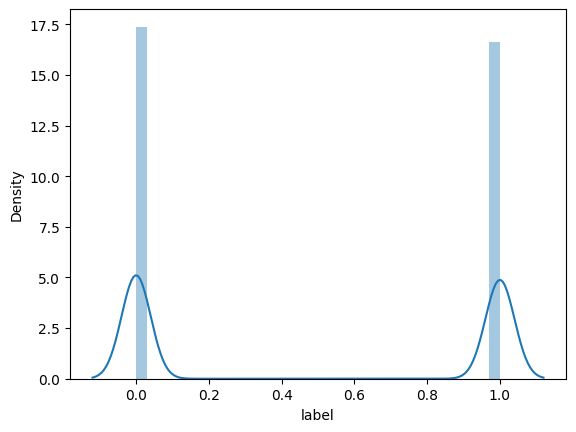

/tmp/ipykernel_1462617/3831127953.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


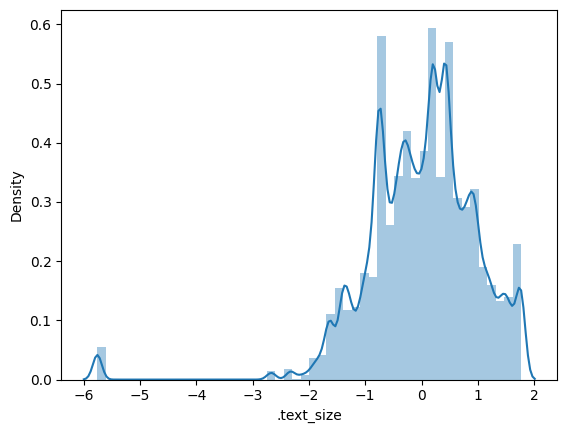

/tmp/ipykernel_1462617/3831127953.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


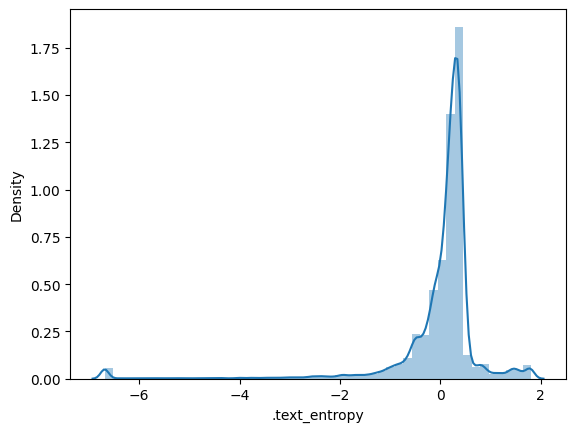

/tmp/ipykernel_1462617/3831127953.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


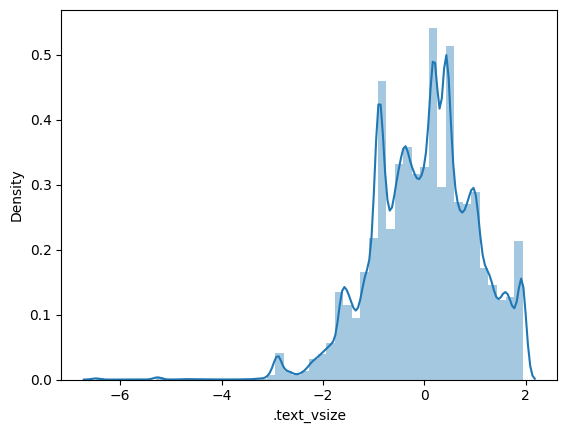

/tmp/ipykernel_1462617/3831127953.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


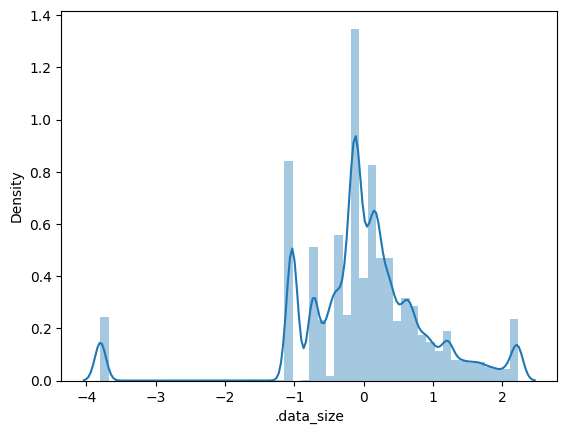

/tmp/ipykernel_1462617/3831127953.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


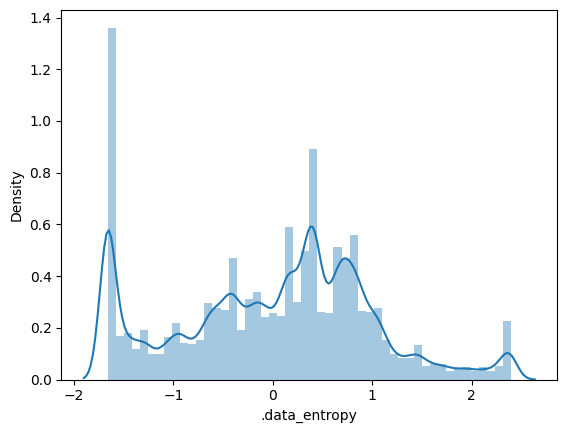

/tmp/ipykernel_1462617/3831127953.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


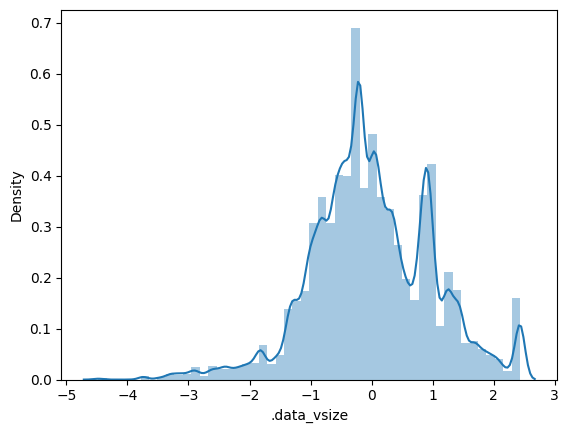

/tmp/ipykernel_1462617/3831127953.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


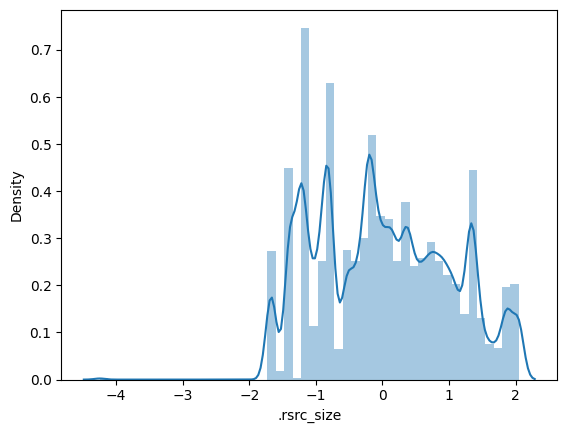

/tmp/ipykernel_1462617/3831127953.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


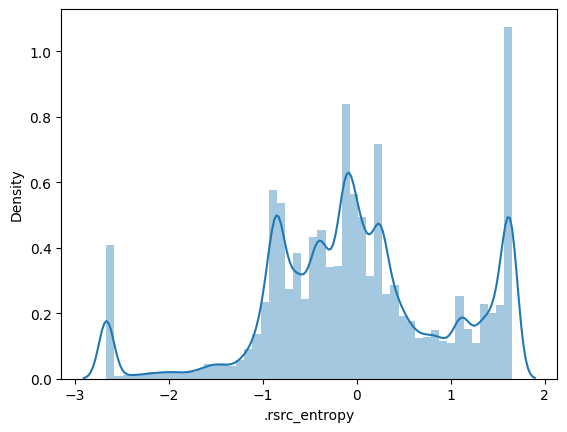

/tmp/ipykernel_1462617/3831127953.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


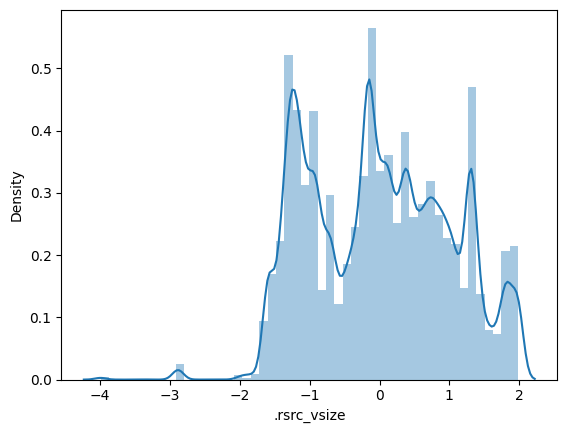

/tmp/ipykernel_1462617/3831127953.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


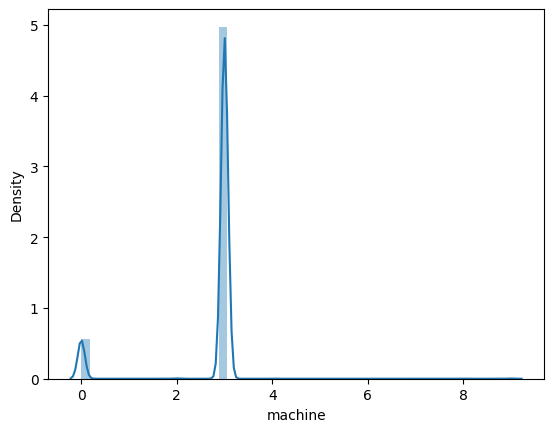

/tmp/ipykernel_1462617/3831127953.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


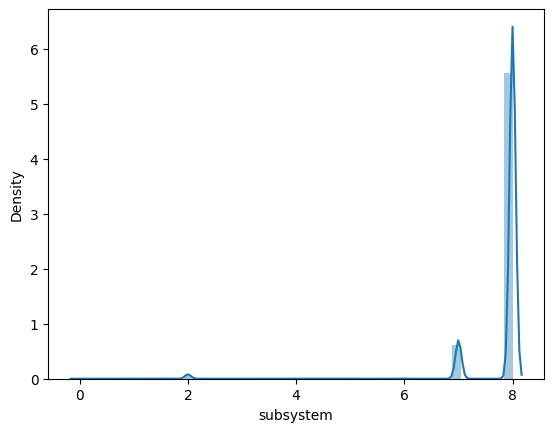

/tmp/ipykernel_1462617/3831127953.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


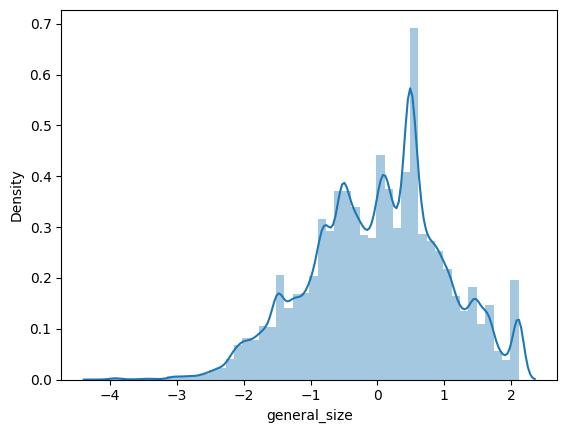

/tmp/ipykernel_1462617/3831127953.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


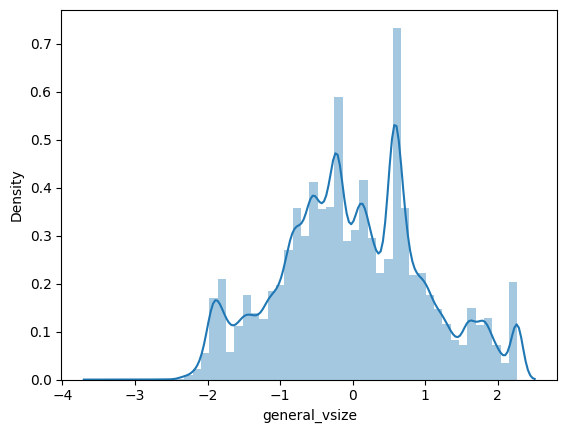

/tmp/ipykernel_1462617/3831127953.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


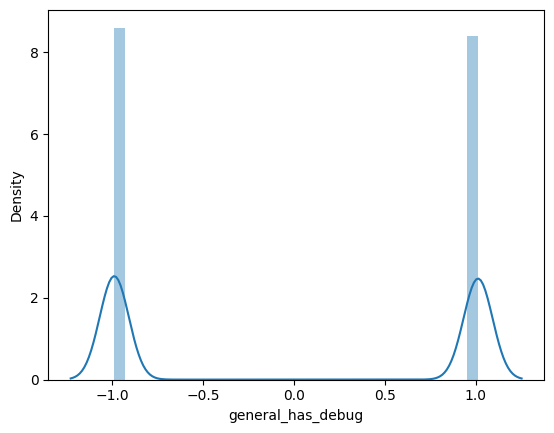

/tmp/ipykernel_1462617/3831127953.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


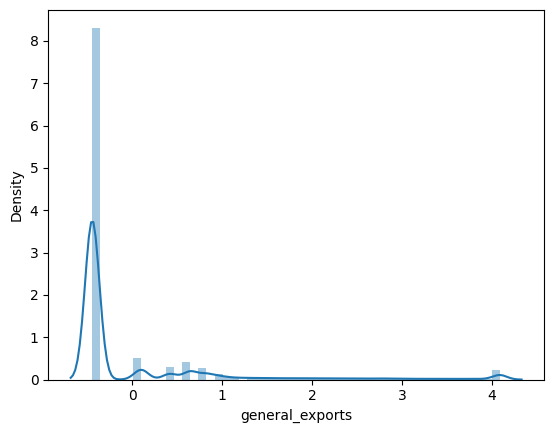

/tmp/ipykernel_1462617/3831127953.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


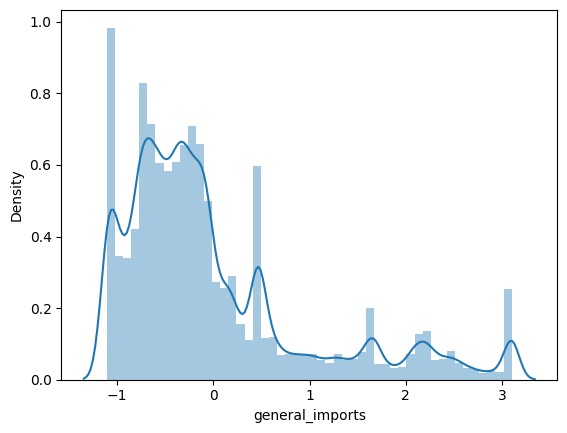

/tmp/ipykernel_1462617/3831127953.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


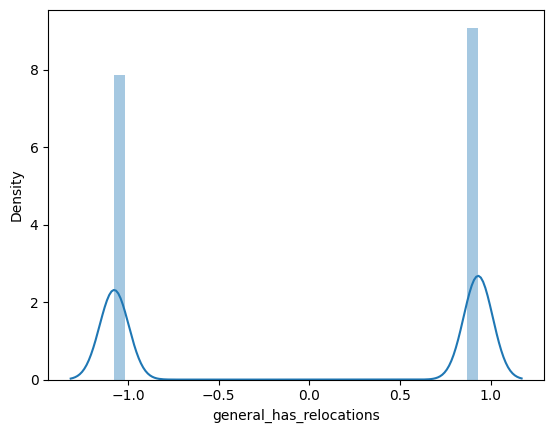

/tmp/ipykernel_1462617/3831127953.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


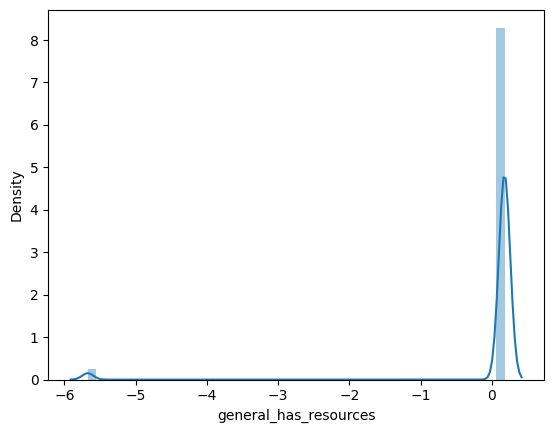

/tmp/ipykernel_1462617/3831127953.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


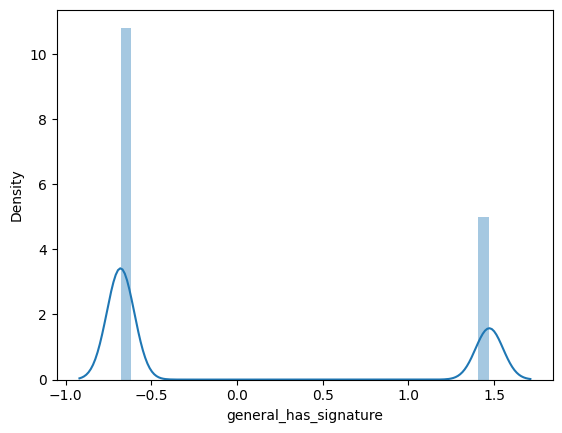

/tmp/ipykernel_1462617/3831127953.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


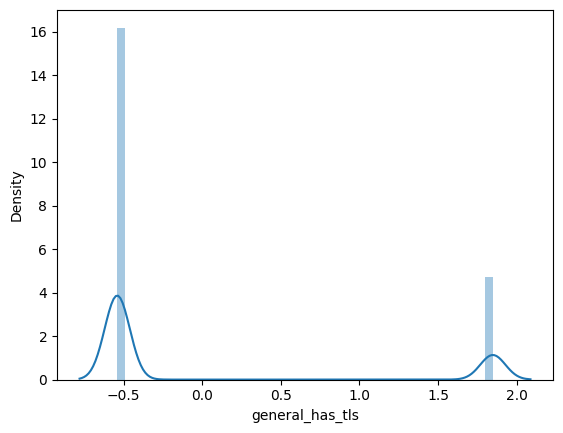

/tmp/ipykernel_1462617/3831127953.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])
/home/devnath/anaconda3/envs/ember_tf/lib/python3.10/site-packages/seaborn/distributions.py:2496: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)


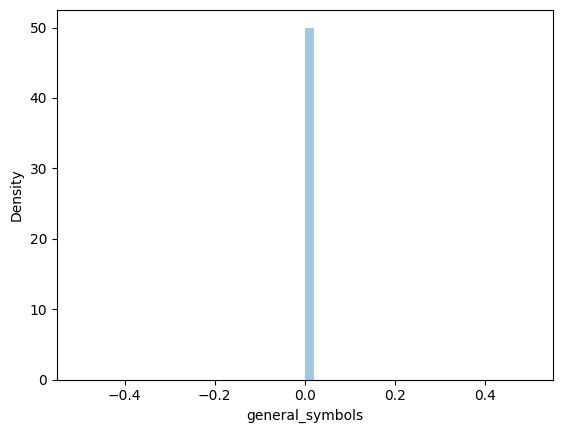

/tmp/ipykernel_1462617/3831127953.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


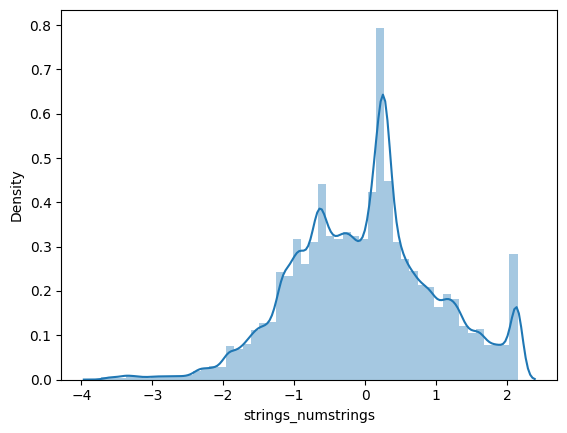

/tmp/ipykernel_1462617/3831127953.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


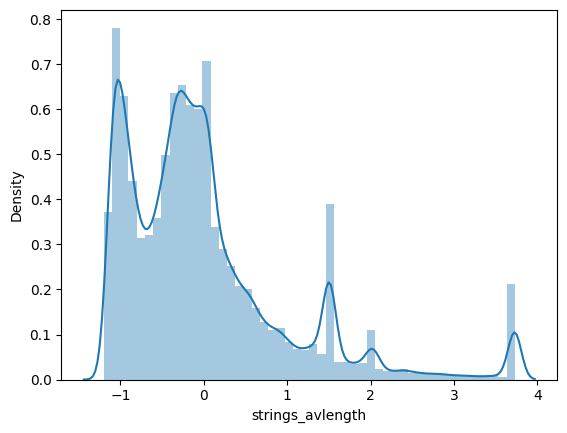

/tmp/ipykernel_1462617/3831127953.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


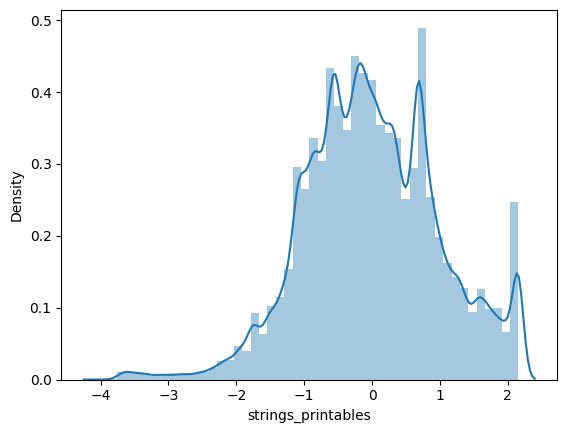

/tmp/ipykernel_1462617/3831127953.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


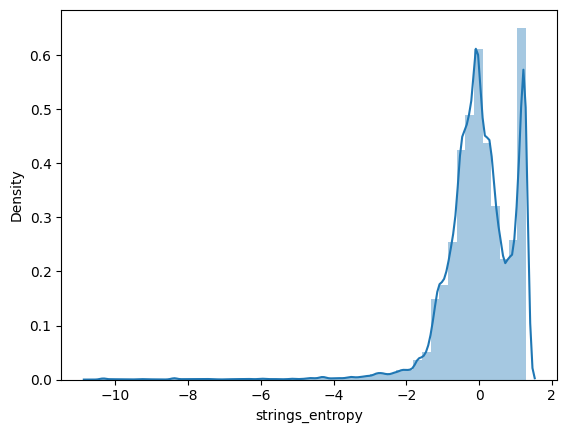

/tmp/ipykernel_1462617/3831127953.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


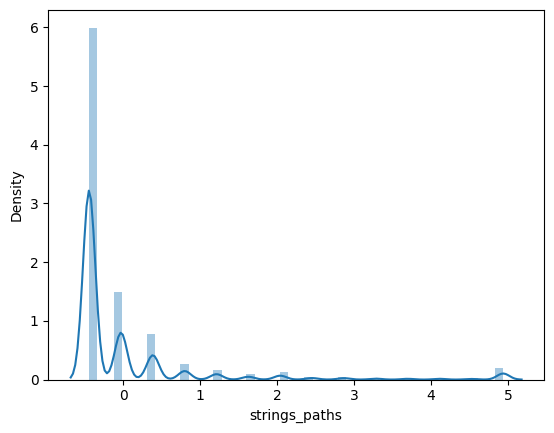

/tmp/ipykernel_1462617/3831127953.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


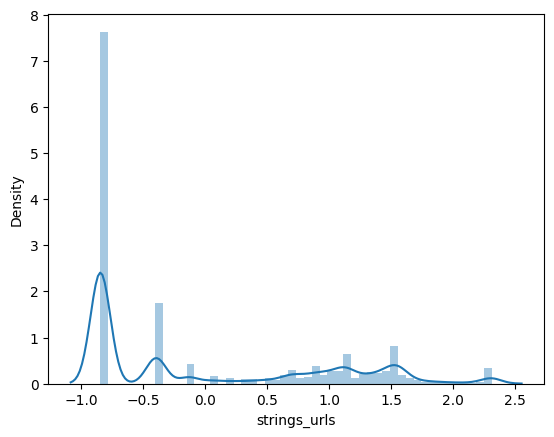

/tmp/ipykernel_1462617/3831127953.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


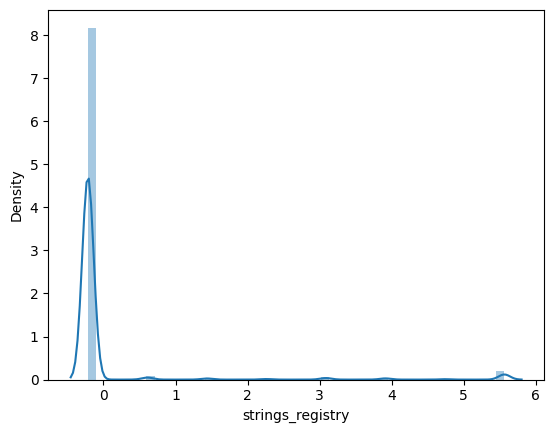

/tmp/ipykernel_1462617/3831127953.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


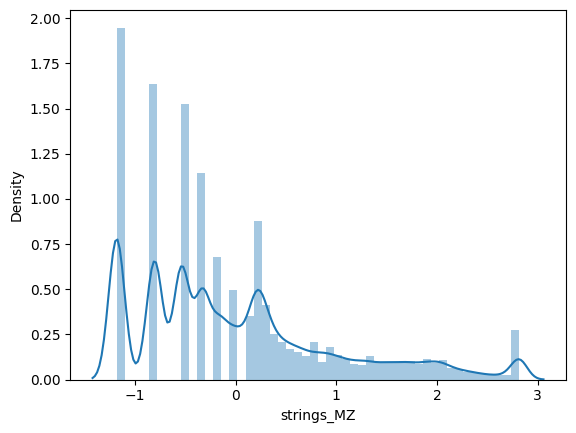

/tmp/ipykernel_1462617/3831127953.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


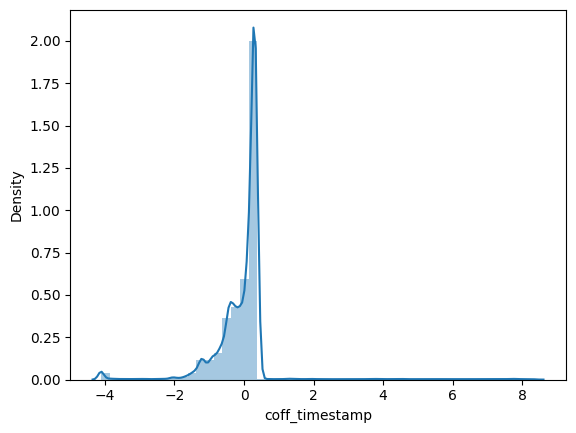

/tmp/ipykernel_1462617/3831127953.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


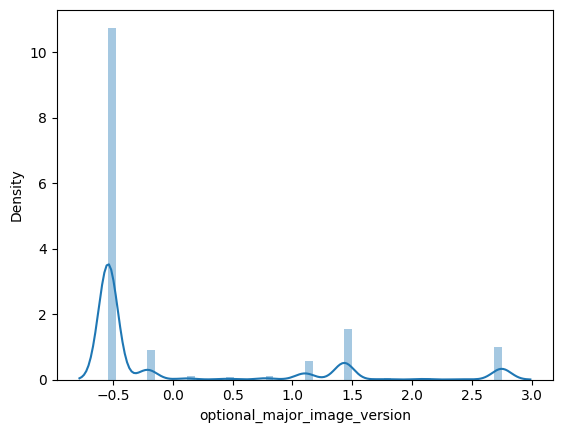

/tmp/ipykernel_1462617/3831127953.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


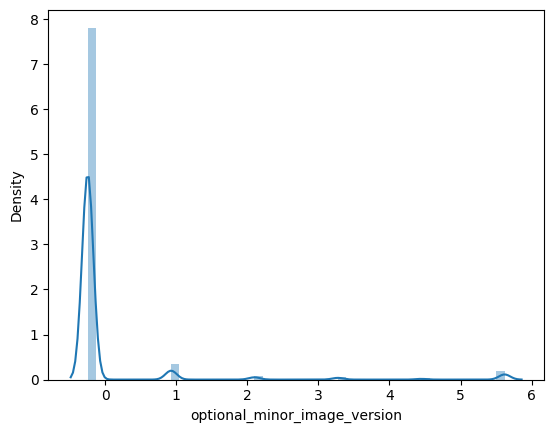

/tmp/ipykernel_1462617/3831127953.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


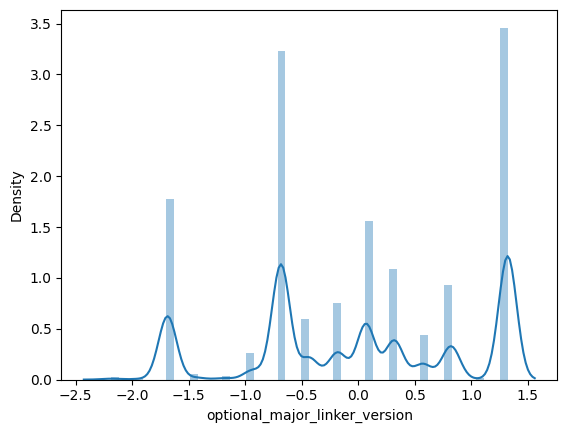

/tmp/ipykernel_1462617/3831127953.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


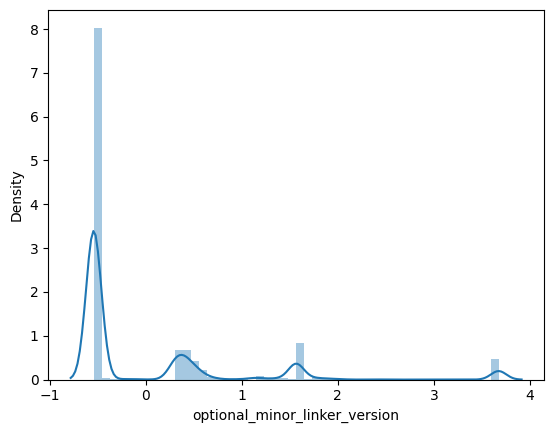

/tmp/ipykernel_1462617/3831127953.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


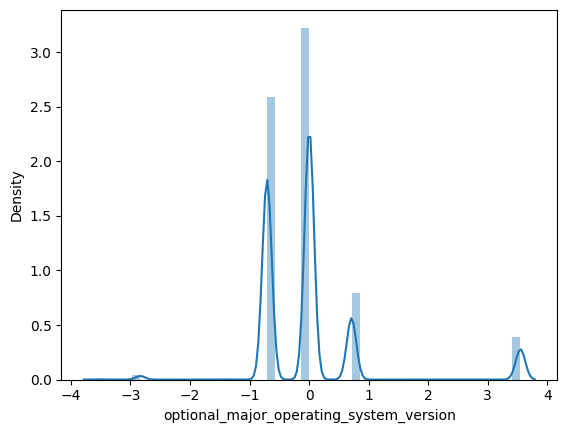

/tmp/ipykernel_1462617/3831127953.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


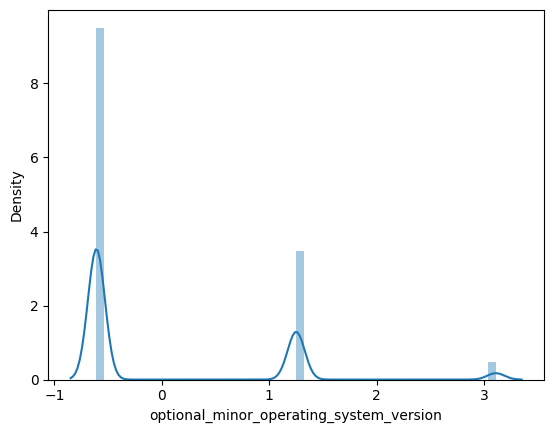

/tmp/ipykernel_1462617/3831127953.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


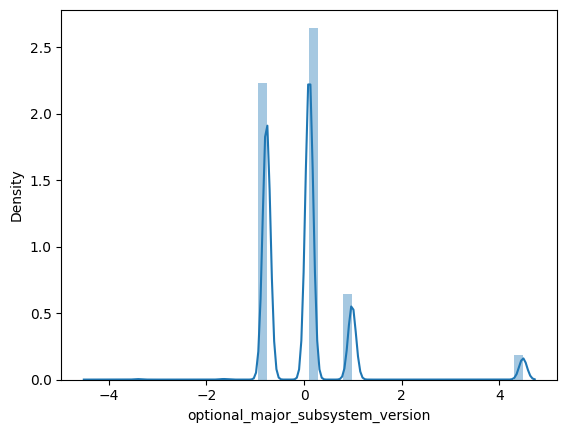

/tmp/ipykernel_1462617/3831127953.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


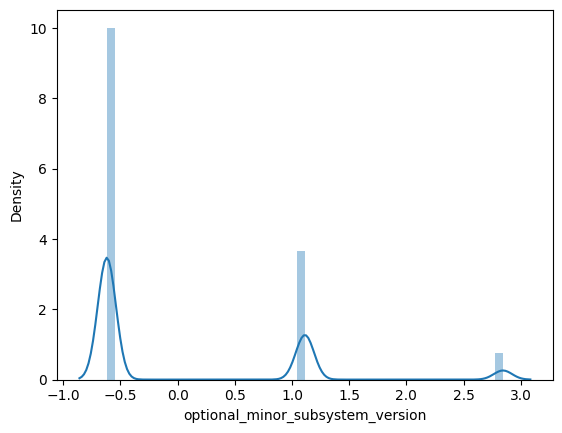

/tmp/ipykernel_1462617/3831127953.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


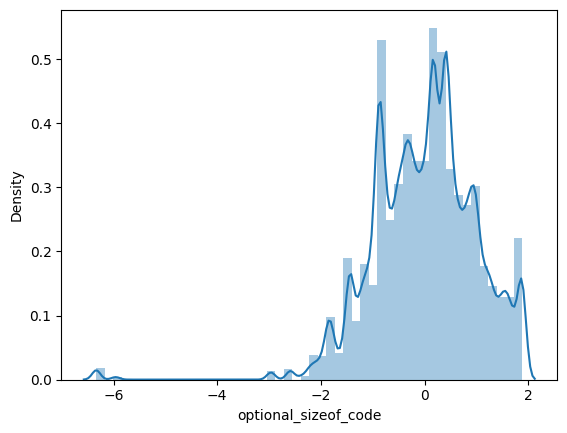

/tmp/ipykernel_1462617/3831127953.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


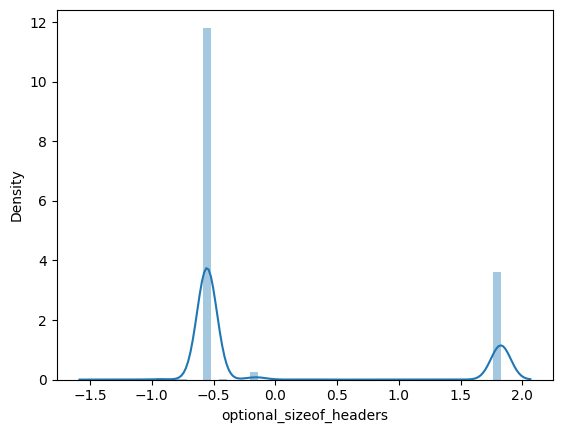

/tmp/ipykernel_1462617/3831127953.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


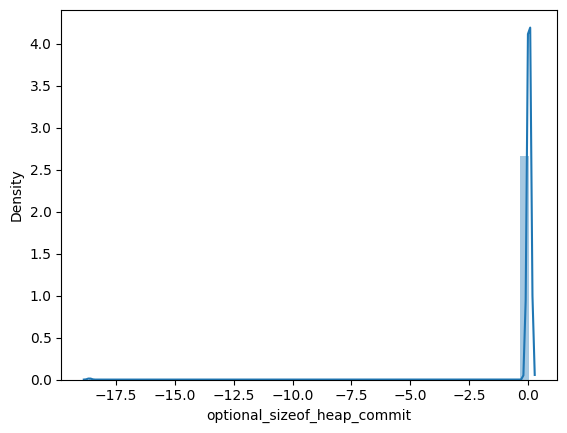

In [57]:
#plot normal distribution of features
def plot_normal_distribution(df):
    for column in df.columns:
        sns.distplot(df[column])
        plt.show()
        
plot_normal_distribution(df_training_standardized)

In [58]:
df_training_standardized.to_csv('/home/devnath/Ember_18_Aug/ember/ember_standard_csv_v3/training.csv',index= False)


In [59]:
df_testing_standardized.to_csv('/home/devnath/Ember_18_Aug/ember/ember_standard_csv_v3/testing.csv',index= False)

In [60]:
df_validation_standardized.to_csv('/home/devnath/Ember_18_Aug/ember/ember_standard_csv_v3/validation.csv',index= False)

In [61]:
import pandas as pd

# Load the datasets
df_training = pd.read_csv('/home/devnath/Ember_18_Aug/ember/ember_standard_csv_v3/training.csv')
df_testing = pd.read_csv('/home/devnath/Ember_18_Aug/ember/ember_standard_csv_v3/testing.csv')
df_validation = pd.read_csv('/home/devnath/Ember_18_Aug/ember/ember_standard_csv_v3/vali.csv')  # Assuming this is the validation set


In [62]:
df_training.head(5)

,label,.text_size,.text_entropy,.text_vsize,.data_size,.data_entropy,.data_vsize,.rsrc_size,.rsrc_entropy,.rsrc_vsize,...,optional_minor_image_version,optional_major_linker_version,optional_minor_linker_version,optional_major_operating_system_version,optional_minor_operating_system_version,optional_major_subsystem_version,optional_minor_subsystem_version,optional_sizeof_code,optional_sizeof_headers,optional_sizeof_heap_commit
0,0,-0.711623,0.253484,-0.848172,-1.034537,-0.777960,1.029338,-0.030385,0.044214,0.024280,...,-0.245765,-0.433505,0.301461,-0.706244,-0.608873,-0.767301,-0.619492,-0.829533,-0.553425,0.053699
1,0,0.694544,0.562345,0.733374,0.192943,1.484576,0.042612,0.115801,-0.673809,0.144632,...,5.620203,-0.433505,0.301461,0.003086,1.249956,-0.767301,-0.619492,0.704574,-0.553425,0.053699
2,0,-0.155133,0.175667,-0.224915,-0.114076,-0.855315,-1.190362,0.417129,0.098972,0.435257,...,-0.245765,-0.684316,-0.541778,0.003086,-0.608873,-0.767301,-0.619492,-0.229206,-0.553425,0.053699
3,0,-0.586135,0.316379,-0.704055,-0.727896,0.416961,-0.421669,1.493452,1.645391,1.458483,...,-0.245765,-0.935127,0.470109,0.003086,-0.608873,-0.767301,-0.619492,-0.692627,-0.156907,0.053699
4,0,-1.265166,-0.025612,-1.485647,-0.727896,0.345247,-1.267801,-1.102540,-0.823501,-1.105272,...,-0.245765,-0.684316,-0.541778,-0.706244,-0.608873,-0.767301,-0.619492,-1.433440,-0.553425,0.053699


In [83]:
import pandas as pd

# Load the datasets
df_train = pd.read_csv('/home/devnath/Ember_18_Aug/ember/ember_standard_csv_v3/training.csv')
df_test = pd.read_csv('/home/devnath/Ember_18_Aug/ember/ember_standard_csv_v3/df_test.csv')
df_val = pd.read_csv('/home/devnath/Ember_18_Aug/ember/ember_standard_csv_v3/df_val.csv')  

In [84]:
X_train = df_train.drop('label', axis= True).values
y_train = df_train['label'].values


In [85]:
X_test = df_test.drop('label', axis= True).values
y_test = df_test['label'].values


In [86]:
X_val = df_val.drop('label', axis= True).values
y_val = df_val['label'].values


In [87]:
X_train.shape

(308453, 41)

In [88]:
y_train.shape

(308453,)

In [89]:
X_test.shape

(83813, 41)

In [91]:
y_val.shape

(26466,)

In [75]:
from sklearn.model_selection import train_test_split
df_val, df_test = train_test_split(df_testing, test_size=0.76)


In [94]:
# Concatenate row-wise (stack DataFrames vertically)
concatenated_df = pd.concat([df_training, df_testing], axis=0, ignore_index=True)

print(concatenated_df)


        label  .text_size  .text_entropy  .text_vsize  .data_size  \
0           0   -0.711623       0.253484    -0.848172   -1.034537   
1           0    0.694544       0.562345     0.733374    0.192943   
2           0   -0.155133       0.175667    -0.224915   -0.114076   
3           0   -0.586135       0.316379    -0.704055   -0.727896   
4           0   -1.265166      -0.025612    -1.485647   -0.727896   
...       ...         ...            ...          ...         ...   
418727      1    0.306556       0.490348     0.303691    0.014746   
418728      1    0.242864       0.471205     0.234596    1.056317   
418729      1   -0.515452       0.230983    -0.660259   -0.131037   
418730      1    1.132959       0.370938     1.205090    1.240540   
418731      0    0.475928      -1.047334     0.488934   -0.448303   

        .data_entropy  .data_vsize  .rsrc_size  .rsrc_entropy  .rsrc_vsize  \
0           -0.777960     1.029338   -0.030385       0.044214     0.024280   
1            1.

In [96]:
 concatenated_df.to_csv('/home/devnath/Ember_18_Aug/ember/ember_standard_csv_v3/final_dataset.csv')

In [106]:
df = pd.read_csv('/home/devnath/Ember_18_Aug/ember/ember_standard_csv_v3/final_dataset.csv')

In [107]:
df.head()

,Unnamed: 0,label,.text_size,.text_entropy,.text_vsize,.data_size,.data_entropy,.data_vsize,.rsrc_size,.rsrc_entropy,...,optional_minor_image_version,optional_major_linker_version,optional_minor_linker_version,optional_major_operating_system_version,optional_minor_operating_system_version,optional_major_subsystem_version,optional_minor_subsystem_version,optional_sizeof_code,optional_sizeof_headers,optional_sizeof_heap_commit
0,0,0,-0.711623,0.253484,-0.848172,-1.034537,-0.777960,1.029338,-0.030385,0.044214,...,-0.245765,-0.433505,0.301461,-0.706244,-0.608873,-0.767301,-0.619492,-0.829533,-0.553425,0.053699
1,1,0,0.694544,0.562345,0.733374,0.192943,1.484576,0.042612,0.115801,-0.673809,...,5.620203,-0.433505,0.301461,0.003086,1.249956,-0.767301,-0.619492,0.704574,-0.553425,0.053699
2,2,0,-0.155133,0.175667,-0.224915,-0.114076,-0.855315,-1.190362,0.417129,0.098972,...,-0.245765,-0.684316,-0.541778,0.003086,-0.608873,-0.767301,-0.619492,-0.229206,-0.553425,0.053699
3,3,0,-0.586135,0.316379,-0.704055,-0.727896,0.416961,-0.421669,1.493452,1.645391,...,-0.245765,-0.935127,0.470109,0.003086,-0.608873,-0.767301,-0.619492,-0.692627,-0.156907,0.053699
4,4,0,-1.265166,-0.025612,-1.485647,-0.727896,0.345247,-1.267801,-1.102540,-0.823501,...,-0.245765,-0.684316,-0.541778,-0.706244,-0.608873,-0.767301,-0.619492,-1.433440,-0.553425,0.053699


In [114]:
def load_data():
    df = pd.read_csv('/home/devnath/Ember_18_Aug/ember/ember_standard_csv_v3/final_dataset.csv')
    # df_target_0 = df[df['target'] == 0].head(20000)
    # df_target_1 = df[df['target'] == 1]
    
    #df_filtered = pd.concat([df_target_0, df_target_1], ignore_index=True)
    X = df.drop(['label','Unnamed: 0'], axis= True).values
    y = df['label'].values
    
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.2,
        random_state=42,
        stratify=df['label']
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_train,
        y_train,
        test_size=0.1,
        random_state=42,
        stratify=y_train
    )

    #     # Create training DataFrame
    # train_df = pd.DataFrame({
    #     'url': X_train,
    #     'label': y_train
    # })
    
    # # Create validation DataFrame
    # val_df = pd.DataFrame({
    #     'url': X_val,
    #     'label': y_val
    # })
    
    # # Create test DataFrame
    # test_df = pd.DataFrame({
    #     'url': X_test,
    #     'label': y_test
    # })

    return X_train, X_test, y_train, y_test, X_val, y_val

In [115]:
X_train, X_test, y_train, y_test, X_val, y_val = load_data()

In [116]:
X_train.shape, y_train.shape,  X_test.shape, y_test.shape, X_val.shape, y_val.shape  

((301486, 41), (301486,), (83747, 41), (83747,), (33499, 41), (33499,))

In [138]:
import numpy as np
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, Conv1D, MaxPooling1D, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Activation
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import KFold

# Base Classifier 1: Simple ANN
def build_ann(input_dim):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(2, activation='softmax'))  # 2 units for binary classification
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [139]:
# # Build the model
input_dim = X_train.shape[1]
model_1 = build_ann(input_dim)

In [140]:
input_dim

41

In [144]:
from tensorflow.keras.utils import to_categorical
# Convert labels to one-hot encoding
y_test = to_categorical(y_test)
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

In [142]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [143]:
# Define the model checkpoint callback
model_checkpoint = ModelCheckpoint(
    filepath='/home/devnath/Ember_18_Aug/ember/ember_standard_csv_v3/ann_40_final_binary_base_classfier.keras', 
    monitor='val_loss', 
    save_best_only=True,
    save_weights_only=False, 
    mode='min', 
    verbose=1
)

# Train the model
history_1 = model_1.fit(X_train, y_train,
                        epochs=40,
                        batch_size=32,
                        validation_data=(X_val, y_val),
                        callbacks=[early_stopping, model_checkpoint])

Epoch 1/40


ValueError: Arguments `target` and `output` must have the same rank (ndim). Received: target.shape=(None, 2, 2, 2, 2), output.shape=(None, 2)

In [124]:
# Print the summary of the model
model_1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 64)             │         2,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 107,720 (420.79 KB)

 Trainable params: 35,906 (140.26 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 71,814 (280.53 KB)

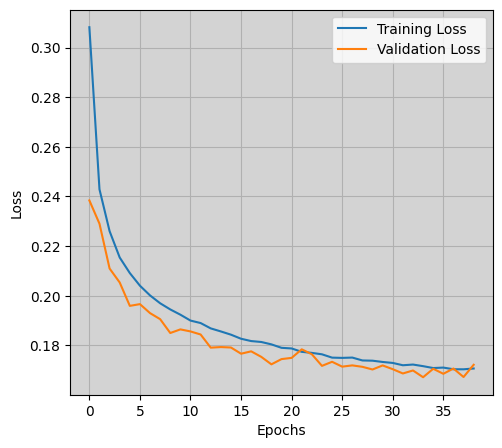

In [125]:
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history_1.history['loss'], label='Training Loss')
plt.plot(history_1.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
# plt.title('Loss')

# Set grid and background color
plt.grid(True)  # Add grid
plt.gca().set_facecolor('lightgrey')  # Set background color of the plot area